# 1. Thêm các thư viện cần thiết

In [127]:
import os
import itertools
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Chuẩn bị dữ liệu

In [111]:
# Nhập dữ liệu từ file
def load_data(data_path):
    X_train = np.load(f'{data_path}/A01T_X.npy')
    y_train = np.load(f'{data_path}/A01T_Y.npy')
    X_test = np.load(f'{data_path}/A01E_X.npy')
    y_test = np.load(f'{data_path}/A01E_Y.npy')

    for i in range(2, 10, 1):
        xt = np.load(f'{data_path}/A0{i}T_X.npy')
        yt = np.load(f'{data_path}/A0{i}T_Y.npy')
        xv = np.load(f'{data_path}/A0{i}E_X.npy')
        yv = np.load(f'{data_path}/A0{i}E_Y.npy')

        X_train = np.concatenate([X_train, xt])
        y_train = np.concatenate([y_train, yt])
        X_test = np.concatenate([X_test, xv])
        y_test = np.concatenate([y_test, yv])

    return X_train, X_test, y_train, y_test

In [112]:
data_path = '/kaggle/input/eeg-preprocessed-data/IndividualData'
X_train, X_test, y_train, y_test = load_data(data_path)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2592, 22, 1875)
y_train shape: (2592,)
X_test shape: (2592, 22, 1875)
y_test shape: (2592,)


In [113]:
class EEGSpectralDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Lấy ảnh và nhãn
        image = self.X[idx]
        label = self.y[idx]

        # Áp dụng biến đổi
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

In [114]:
# Train and test dataset
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_dataset = EEGSpectralDataset(X_train, y_train)
test_dataset = EEGSpectralDataset(X_test, y_test)

# Train and test loader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

img, label = next(iter(train_loader))
print(img.shape, label.shape)
print(label)

torch.Size([16, 1, 22, 1875]) torch.Size([16])
tensor([1, 3, 2, 2, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 1])


# 3. Xây dựng mô hình

In [115]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        # Block 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(0.5)

        # Block 2: Separable Convolution
        self.separable_conv = nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(0.5)

        # Classification block
        self.fc = nn.Linear(F2 * (T // 32), num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.separable_conv(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Classification
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [116]:
# Khởi tạo mô hình
num_classes = 4
eeg_net = EEGNet(num_classes=num_classes)
eeg_net = nn.DataParallel(eeg_net)
print(eeg_net)

DataParallel(
  (module): EEGNet(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise_conv): Conv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu1): ELU(alpha=1.0)
    (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout1): Dropout(p=0.5, inplace=False)
    (separable_conv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu2): ELU(alpha=1.0)
    (pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=928, out_features=4, bias=True)
  )
)


# 4. Huấn luyện và đánh giá mô hình

## 4.1 Định nghĩa các hàm chức năng

In [117]:
def evaluate_model(model, test_loader, criterion, device=None, report=False):
    if device is not None:
        model.to(device)

    model.eval() # Set the model to evaluation mode
    running_loss = 0.0

    true_labels = []
    predicted_labels = []

    # Use torch.no_grad() to disable gradient calculation during evaluation
    with torch.no_grad():
        for images, labels in tqdm(test_loader, unit='batch', desc='Evaluating'):
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predicted_labels)

    labels = list(range(4))
    names = ['Left Hand', 'Right Hand', 'Foot', 'Tongue']
    classification_rep = classification_report(true_labels, predicted_labels, labels=labels, target_names=names, zero_division=0)

    print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')
    if report:
        print(f'\tClassification Report:\n{classification_rep}')
    return epoch_loss, accuracy

In [118]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, save_path, device=None, epochs=10, wandb_writer=None, report=False):
    if device is not None:
        model.to(device)
    model.train()

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    best_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0

        true_labels = []
        predicted_labels = []

        for images, labels in tqdm(train_loader, unit='batch', desc=f'Training epoch [{epoch+1}/{epochs}]'):
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        accuracy = accuracy_score(true_labels, predicted_labels)
        train_acc.append(accuracy)
        print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')

        test_loss, test_ac = evaluate_model(model, test_loader, criterion, device)
        model.train()
        test_losses.append(test_loss)
        test_acc.append(test_ac)
        if wandb_writer is not None:
            wandb_writer.log({
                "Train loss": epoch_loss,
                "Train accuracy": accuracy,
                "Test loss": test_loss,
                "Test accuracy": test_ac
            })

        if test_ac > best_acc:
            best_acc = test_ac
            torch.save(model.state_dict(), save_path)
            print('Model is saved to ', save_path)
            if wandb_writer is not None:
                wandb_writer.save(save_path)
        print("====================================================================")

    if wandb_writer is not None:
        wandb_writer.finish()
    return train_losses, train_acc, test_losses, test_acc

## 4.2. Thực nghiệm trên mô hình

In [119]:
# !pip install wandb

# import wandb
# wandb.login()

In [120]:
lr=0.001
weight_decay=1e-4
step_size=10
gamma=0.5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eeg_net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [121]:
# eeg_wan_writer = wandb.init(
#     project="motor imagery",
#     name="EEG-Net",
#     config={
#         "learning_rate": lr,
#         "weight_decay": weight_decay,
#         "step_size": step_size,
#         "gamma": gamma,
#         "optimizer": "Adam",
#         "scheduler": "StepLR",
#         "criterion": "CrossEntropyLoss",
#     }
# )

In [122]:
epochs = 200
save_path = '/kaggle/working/eeg_net.pth'
train_losses, train_acc, test_losses, test_acc = train_model(eeg_net, train_loader, test_loader, 
                                                             criterion, optimizer, scheduler, 
                                                             save_path, device, 
                                                             epochs=epochs, wandb_writer=None)

Training epoch [1/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [1/200]: 100%|██████████| 162/162 [00:01<00:00, 81.65batch/s]


	---> Loss: 1.3544
	---> Accuracy: 0.3314


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.95batch/s]


	---> Loss: 1.2674
	---> Accuracy: 0.4051
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [2/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/200]: 100%|██████████| 162/162 [00:01<00:00, 81.07batch/s]


	---> Loss: 1.2043
	---> Accuracy: 0.4614


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.67batch/s]


	---> Loss: 1.2028
	---> Accuracy: 0.4603
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [3/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/200]: 100%|██████████| 162/162 [00:01<00:00, 82.54batch/s]


	---> Loss: 1.1313
	---> Accuracy: 0.4981


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 124.54batch/s]


	---> Loss: 1.1609
	---> Accuracy: 0.4819
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [4/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/200]: 100%|██████████| 162/162 [00:02<00:00, 76.43batch/s]


	---> Loss: 1.0740
	---> Accuracy: 0.5405


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.70batch/s]


	---> Loss: 1.0900
	---> Accuracy: 0.5305
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [5/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [5/200]: 100%|██████████| 162/162 [00:01<00:00, 82.84batch/s]


	---> Loss: 1.0171
	---> Accuracy: 0.5714


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.73batch/s]


	---> Loss: 1.0627
	---> Accuracy: 0.5505
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [6/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [6/200]: 100%|██████████| 162/162 [00:01<00:00, 81.42batch/s]


	---> Loss: 0.9831
	---> Accuracy: 0.5864


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 108.28batch/s]


	---> Loss: 1.0083
	---> Accuracy: 0.5756
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [7/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [7/200]: 100%|██████████| 162/162 [00:02<00:00, 80.46batch/s]


	---> Loss: 0.9491
	---> Accuracy: 0.6053


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.29batch/s]


	---> Loss: 0.9761
	---> Accuracy: 0.5891
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [8/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [8/200]: 100%|██████████| 162/162 [00:01<00:00, 82.66batch/s]


	---> Loss: 0.9290
	---> Accuracy: 0.6238


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.58batch/s]


	---> Loss: 0.9631
	---> Accuracy: 0.5984
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [9/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [9/200]: 100%|██████████| 162/162 [00:01<00:00, 82.09batch/s]


	---> Loss: 0.9090
	---> Accuracy: 0.6327


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.62batch/s]


	---> Loss: 0.9337
	---> Accuracy: 0.6142
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [10/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [10/200]: 100%|██████████| 162/162 [00:01<00:00, 81.86batch/s]


	---> Loss: 0.9010
	---> Accuracy: 0.6339


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.51batch/s]


	---> Loss: 0.9435
	---> Accuracy: 0.6111


Training epoch [11/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [11/200]: 100%|██████████| 162/162 [00:02<00:00, 79.63batch/s]


	---> Loss: 0.8269
	---> Accuracy: 0.6640


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.88batch/s]


	---> Loss: 0.9077
	---> Accuracy: 0.6204
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [12/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [12/200]: 100%|██████████| 162/162 [00:02<00:00, 79.64batch/s]


	---> Loss: 0.8143
	---> Accuracy: 0.6744


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.24batch/s]


	---> Loss: 0.8934
	---> Accuracy: 0.6373
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [13/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [13/200]: 100%|██████████| 162/162 [00:02<00:00, 80.39batch/s]


	---> Loss: 0.8026
	---> Accuracy: 0.6813


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.55batch/s]


	---> Loss: 0.8778
	---> Accuracy: 0.6458
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [14/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [14/200]: 100%|██████████| 162/162 [00:01<00:00, 82.99batch/s]


	---> Loss: 0.8062
	---> Accuracy: 0.6840


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.89batch/s]


	---> Loss: 0.8680
	---> Accuracy: 0.6539
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [15/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [15/200]: 100%|██████████| 162/162 [00:01<00:00, 84.42batch/s]


	---> Loss: 0.7794
	---> Accuracy: 0.6917


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.50batch/s]


	---> Loss: 0.8695
	---> Accuracy: 0.6547
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [16/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [16/200]: 100%|██████████| 162/162 [00:02<00:00, 74.11batch/s]


	---> Loss: 0.7917
	---> Accuracy: 0.6836


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 121.63batch/s]


	---> Loss: 0.8834
	---> Accuracy: 0.6489


Training epoch [17/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [17/200]: 100%|██████████| 162/162 [00:01<00:00, 81.87batch/s]


	---> Loss: 0.7816
	---> Accuracy: 0.6890


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.87batch/s]


	---> Loss: 0.8645
	---> Accuracy: 0.6493


Training epoch [18/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [18/200]: 100%|██████████| 162/162 [00:01<00:00, 84.29batch/s]


	---> Loss: 0.7682
	---> Accuracy: 0.6898


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.09batch/s]


	---> Loss: 0.8504
	---> Accuracy: 0.6605
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [19/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [19/200]: 100%|██████████| 162/162 [00:02<00:00, 78.59batch/s]


	---> Loss: 0.7590
	---> Accuracy: 0.6964


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.79batch/s]


	---> Loss: 0.8462
	---> Accuracy: 0.6694
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [20/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [20/200]: 100%|██████████| 162/162 [00:01<00:00, 81.82batch/s]


	---> Loss: 0.7678
	---> Accuracy: 0.6921


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.05batch/s]


	---> Loss: 0.8336
	---> Accuracy: 0.6628


Training epoch [21/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [21/200]: 100%|██████████| 162/162 [00:01<00:00, 83.26batch/s]


	---> Loss: 0.7402
	---> Accuracy: 0.7072


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.71batch/s]


	---> Loss: 0.8379
	---> Accuracy: 0.6620


Training epoch [22/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [22/200]: 100%|██████████| 162/162 [00:01<00:00, 82.04batch/s]


	---> Loss: 0.7351
	---> Accuracy: 0.7087


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.24batch/s]


	---> Loss: 0.8232
	---> Accuracy: 0.6744
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [23/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [23/200]: 100%|██████████| 162/162 [00:01<00:00, 84.22batch/s]


	---> Loss: 0.7060
	---> Accuracy: 0.7145


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.84batch/s]


	---> Loss: 0.8225
	---> Accuracy: 0.6721


Training epoch [24/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [24/200]: 100%|██████████| 162/162 [00:01<00:00, 82.42batch/s]


	---> Loss: 0.7161
	---> Accuracy: 0.7122


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.17batch/s]


	---> Loss: 0.8183
	---> Accuracy: 0.6717


Training epoch [25/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [25/200]: 100%|██████████| 162/162 [00:02<00:00, 80.70batch/s]


	---> Loss: 0.7200
	---> Accuracy: 0.7172


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.89batch/s]


	---> Loss: 0.8131
	---> Accuracy: 0.6794
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [26/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [26/200]: 100%|██████████| 162/162 [00:02<00:00, 76.66batch/s]


	---> Loss: 0.7054
	---> Accuracy: 0.7245


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.86batch/s]


	---> Loss: 0.8116
	---> Accuracy: 0.6829
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [27/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [27/200]: 100%|██████████| 162/162 [00:01<00:00, 82.31batch/s]


	---> Loss: 0.6971
	---> Accuracy: 0.7361


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.73batch/s]


	---> Loss: 0.8092
	---> Accuracy: 0.6802


Training epoch [28/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [28/200]: 100%|██████████| 162/162 [00:01<00:00, 84.30batch/s]


	---> Loss: 0.7038
	---> Accuracy: 0.7226


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.59batch/s]


	---> Loss: 0.8102
	---> Accuracy: 0.6763


Training epoch [29/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [29/200]: 100%|██████████| 162/162 [00:01<00:00, 81.61batch/s]


	---> Loss: 0.7195
	---> Accuracy: 0.7226


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.48batch/s]


	---> Loss: 0.8044
	---> Accuracy: 0.6829


Training epoch [30/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [30/200]: 100%|██████████| 162/162 [00:01<00:00, 82.39batch/s]


	---> Loss: 0.7246
	---> Accuracy: 0.7079


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.19batch/s]


	---> Loss: 0.7984
	---> Accuracy: 0.6825


Training epoch [31/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [31/200]: 100%|██████████| 162/162 [00:01<00:00, 84.74batch/s]


	---> Loss: 0.6932
	---> Accuracy: 0.7272


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.09batch/s]


	---> Loss: 0.7940
	---> Accuracy: 0.6840
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [32/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [32/200]: 100%|██████████| 162/162 [00:01<00:00, 82.92batch/s]


	---> Loss: 0.6752
	---> Accuracy: 0.7338


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.11batch/s]


	---> Loss: 0.7989
	---> Accuracy: 0.6844
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [33/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [33/200]: 100%|██████████| 162/162 [00:01<00:00, 82.40batch/s]


	---> Loss: 0.6875
	---> Accuracy: 0.7315


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.25batch/s]


	---> Loss: 0.8032
	---> Accuracy: 0.6782


Training epoch [34/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [34/200]: 100%|██████████| 162/162 [00:01<00:00, 81.63batch/s]


	---> Loss: 0.6976
	---> Accuracy: 0.7249


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.81batch/s]


	---> Loss: 0.8015
	---> Accuracy: 0.6802


Training epoch [35/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [35/200]: 100%|██████████| 162/162 [00:01<00:00, 83.80batch/s]


	---> Loss: 0.6903
	---> Accuracy: 0.7400


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.84batch/s]


	---> Loss: 0.7902
	---> Accuracy: 0.6902
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [36/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [36/200]: 100%|██████████| 162/162 [00:02<00:00, 73.48batch/s]


	---> Loss: 0.6962
	---> Accuracy: 0.7149


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.39batch/s]


	---> Loss: 0.7966
	---> Accuracy: 0.6875


Training epoch [37/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [37/200]: 100%|██████████| 162/162 [00:01<00:00, 82.44batch/s]


	---> Loss: 0.6786
	---> Accuracy: 0.7307


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.27batch/s]


	---> Loss: 0.7957
	---> Accuracy: 0.6883


Training epoch [38/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [38/200]: 100%|██████████| 162/162 [00:01<00:00, 84.73batch/s]


	---> Loss: 0.6716
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.10batch/s]


	---> Loss: 0.8019
	---> Accuracy: 0.6809


Training epoch [39/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [39/200]: 100%|██████████| 162/162 [00:01<00:00, 85.57batch/s]


	---> Loss: 0.6883
	---> Accuracy: 0.7288


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.36batch/s]


	---> Loss: 0.7897
	---> Accuracy: 0.6898


Training epoch [40/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [40/200]: 100%|██████████| 162/162 [00:01<00:00, 81.63batch/s]


	---> Loss: 0.6940
	---> Accuracy: 0.7253


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.81batch/s]


	---> Loss: 0.7924
	---> Accuracy: 0.6863


Training epoch [41/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [41/200]: 100%|██████████| 162/162 [00:02<00:00, 79.93batch/s]


	---> Loss: 0.6787
	---> Accuracy: 0.7330


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.79batch/s]


	---> Loss: 0.7843
	---> Accuracy: 0.6979
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [42/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [42/200]: 100%|██████████| 162/162 [00:01<00:00, 82.11batch/s]


	---> Loss: 0.6763
	---> Accuracy: 0.7334


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.49batch/s]


	---> Loss: 0.7876
	---> Accuracy: 0.6952


Training epoch [43/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [43/200]: 100%|██████████| 162/162 [00:01<00:00, 82.93batch/s]


	---> Loss: 0.6681
	---> Accuracy: 0.7407


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.02batch/s]


	---> Loss: 0.7855
	---> Accuracy: 0.6917


Training epoch [44/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [44/200]: 100%|██████████| 162/162 [00:01<00:00, 82.89batch/s]


	---> Loss: 0.6821
	---> Accuracy: 0.7342


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.73batch/s]


	---> Loss: 0.7881
	---> Accuracy: 0.6944


Training epoch [45/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [45/200]: 100%|██████████| 162/162 [00:01<00:00, 81.24batch/s]


	---> Loss: 0.6854
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.19batch/s]


	---> Loss: 0.7858
	---> Accuracy: 0.6964


Training epoch [46/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [46/200]: 100%|██████████| 162/162 [00:02<00:00, 72.84batch/s]


	---> Loss: 0.6729
	---> Accuracy: 0.7307


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.58batch/s]


	---> Loss: 0.7879
	---> Accuracy: 0.6995
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [47/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [47/200]: 100%|██████████| 162/162 [00:02<00:00, 80.74batch/s]


	---> Loss: 0.6565
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.53batch/s]


	---> Loss: 0.7909
	---> Accuracy: 0.6948


Training epoch [48/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [48/200]: 100%|██████████| 162/162 [00:01<00:00, 82.78batch/s]


	---> Loss: 0.6647
	---> Accuracy: 0.7361


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.99batch/s]


	---> Loss: 0.7844
	---> Accuracy: 0.6983


Training epoch [49/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [49/200]: 100%|██████████| 162/162 [00:01<00:00, 82.09batch/s]


	---> Loss: 0.6819
	---> Accuracy: 0.7396


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.78batch/s]


	---> Loss: 0.7844
	---> Accuracy: 0.6956


Training epoch [50/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [50/200]: 100%|██████████| 162/162 [00:02<00:00, 80.73batch/s]


	---> Loss: 0.6715
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.95batch/s]


	---> Loss: 0.7834
	---> Accuracy: 0.6964


Training epoch [51/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [51/200]: 100%|██████████| 162/162 [00:01<00:00, 84.09batch/s]


	---> Loss: 0.6619
	---> Accuracy: 0.7377


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.96batch/s]


	---> Loss: 0.7925
	---> Accuracy: 0.6921


Training epoch [52/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [52/200]: 100%|██████████| 162/162 [00:01<00:00, 82.74batch/s]


	---> Loss: 0.6684
	---> Accuracy: 0.7384


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.92batch/s]


	---> Loss: 0.7889
	---> Accuracy: 0.6910


Training epoch [53/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [53/200]: 100%|██████████| 162/162 [00:01<00:00, 82.40batch/s]


	---> Loss: 0.6559
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.02batch/s]


	---> Loss: 0.7816
	---> Accuracy: 0.6975


Training epoch [54/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [54/200]: 100%|██████████| 162/162 [00:01<00:00, 83.29batch/s]


	---> Loss: 0.6519
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.55batch/s]


	---> Loss: 0.7795
	---> Accuracy: 0.6991


Training epoch [55/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [55/200]: 100%|██████████| 162/162 [00:01<00:00, 84.77batch/s]


	---> Loss: 0.6402
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.34batch/s]


	---> Loss: 0.7813
	---> Accuracy: 0.6998
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [56/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [56/200]: 100%|██████████| 162/162 [00:02<00:00, 76.54batch/s]


	---> Loss: 0.6515
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.64batch/s]


	---> Loss: 0.7899
	---> Accuracy: 0.6933


Training epoch [57/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [57/200]: 100%|██████████| 162/162 [00:01<00:00, 83.38batch/s]


	---> Loss: 0.6711
	---> Accuracy: 0.7311


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.10batch/s]


	---> Loss: 0.7844
	---> Accuracy: 0.6952


Training epoch [58/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [58/200]: 100%|██████████| 162/162 [00:01<00:00, 82.91batch/s]


	---> Loss: 0.6680
	---> Accuracy: 0.7400


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.70batch/s]


	---> Loss: 0.7814
	---> Accuracy: 0.7014
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [59/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [59/200]: 100%|██████████| 162/162 [00:01<00:00, 82.31batch/s]


	---> Loss: 0.6728
	---> Accuracy: 0.7377


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.39batch/s]


	---> Loss: 0.7820
	---> Accuracy: 0.6979


Training epoch [60/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [60/200]: 100%|██████████| 162/162 [00:01<00:00, 82.90batch/s]


	---> Loss: 0.6558
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.07batch/s]


	---> Loss: 0.7885
	---> Accuracy: 0.6944


Training epoch [61/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [61/200]: 100%|██████████| 162/162 [00:01<00:00, 84.06batch/s]


	---> Loss: 0.6425
	---> Accuracy: 0.7566


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.58batch/s]


	---> Loss: 0.7817
	---> Accuracy: 0.6960


Training epoch [62/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [62/200]: 100%|██████████| 162/162 [00:01<00:00, 82.84batch/s]


	---> Loss: 0.6545
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.38batch/s]


	---> Loss: 0.7882
	---> Accuracy: 0.6941


Training epoch [63/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [63/200]: 100%|██████████| 162/162 [00:01<00:00, 83.63batch/s]


	---> Loss: 0.6419
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.38batch/s]


	---> Loss: 0.7920
	---> Accuracy: 0.6894


Training epoch [64/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [64/200]: 100%|██████████| 162/162 [00:01<00:00, 83.71batch/s]


	---> Loss: 0.6567
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.55batch/s]


	---> Loss: 0.7817
	---> Accuracy: 0.6960


Training epoch [65/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [65/200]: 100%|██████████| 162/162 [00:01<00:00, 82.24batch/s]


	---> Loss: 0.6606
	---> Accuracy: 0.7396


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 120.05batch/s]


	---> Loss: 0.7902
	---> Accuracy: 0.6883


Training epoch [66/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [66/200]: 100%|██████████| 162/162 [00:02<00:00, 76.86batch/s]


	---> Loss: 0.6613
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.71batch/s]


	---> Loss: 0.7828
	---> Accuracy: 0.6968


Training epoch [67/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [67/200]: 100%|██████████| 162/162 [00:01<00:00, 83.64batch/s]


	---> Loss: 0.6825
	---> Accuracy: 0.7195


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.99batch/s]


	---> Loss: 0.7872
	---> Accuracy: 0.6917


Training epoch [68/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [68/200]: 100%|██████████| 162/162 [00:01<00:00, 83.15batch/s]


	---> Loss: 0.6740
	---> Accuracy: 0.7319


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.86batch/s]


	---> Loss: 0.7788
	---> Accuracy: 0.6944


Training epoch [69/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [69/200]: 100%|██████████| 162/162 [00:01<00:00, 83.82batch/s]


	---> Loss: 0.6515
	---> Accuracy: 0.7361


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.47batch/s]


	---> Loss: 0.7811
	---> Accuracy: 0.6971


Training epoch [70/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [70/200]: 100%|██████████| 162/162 [00:01<00:00, 83.27batch/s]


	---> Loss: 0.6529
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.21batch/s]


	---> Loss: 0.7826
	---> Accuracy: 0.6933


Training epoch [71/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [71/200]: 100%|██████████| 162/162 [00:01<00:00, 81.54batch/s]


	---> Loss: 0.6666
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.70batch/s]


	---> Loss: 0.7887
	---> Accuracy: 0.6871


Training epoch [72/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [72/200]: 100%|██████████| 162/162 [00:02<00:00, 79.84batch/s]


	---> Loss: 0.6663
	---> Accuracy: 0.7373


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.77batch/s]


	---> Loss: 0.7739
	---> Accuracy: 0.7002


Training epoch [73/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [73/200]: 100%|██████████| 162/162 [00:01<00:00, 82.21batch/s]


	---> Loss: 0.6717
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.09batch/s]


	---> Loss: 0.7775
	---> Accuracy: 0.6995


Training epoch [74/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [74/200]: 100%|██████████| 162/162 [00:01<00:00, 83.55batch/s]


	---> Loss: 0.6490
	---> Accuracy: 0.7303


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.34batch/s]


	---> Loss: 0.7858
	---> Accuracy: 0.6948


Training epoch [75/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [75/200]: 100%|██████████| 162/162 [00:01<00:00, 82.55batch/s]


	---> Loss: 0.6581
	---> Accuracy: 0.7419


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 119.75batch/s]


	---> Loss: 0.7883
	---> Accuracy: 0.6914


Training epoch [76/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [76/200]: 100%|██████████| 162/162 [00:02<00:00, 80.88batch/s]


	---> Loss: 0.6639
	---> Accuracy: 0.7423


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.09batch/s]


	---> Loss: 0.7862
	---> Accuracy: 0.6929


Training epoch [77/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [77/200]: 100%|██████████| 162/162 [00:01<00:00, 84.32batch/s]


	---> Loss: 0.6741
	---> Accuracy: 0.7357


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.80batch/s]


	---> Loss: 0.7834
	---> Accuracy: 0.6948


Training epoch [78/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [78/200]: 100%|██████████| 162/162 [00:01<00:00, 84.01batch/s]


	---> Loss: 0.6728
	---> Accuracy: 0.7276


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.66batch/s]


	---> Loss: 0.7837
	---> Accuracy: 0.6964


Training epoch [79/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [79/200]: 100%|██████████| 162/162 [00:01<00:00, 84.34batch/s]


	---> Loss: 0.6710
	---> Accuracy: 0.7357


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.38batch/s]


	---> Loss: 0.7798
	---> Accuracy: 0.6991


Training epoch [80/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [80/200]: 100%|██████████| 162/162 [00:01<00:00, 81.82batch/s]


	---> Loss: 0.6446
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.90batch/s]


	---> Loss: 0.7921
	---> Accuracy: 0.6902


Training epoch [81/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [81/200]: 100%|██████████| 162/162 [00:01<00:00, 82.72batch/s]


	---> Loss: 0.6622
	---> Accuracy: 0.7461


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.10batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6971


Training epoch [82/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [82/200]: 100%|██████████| 162/162 [00:01<00:00, 83.91batch/s]


	---> Loss: 0.6479
	---> Accuracy: 0.7392


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.21batch/s]


	---> Loss: 0.7843
	---> Accuracy: 0.6975


Training epoch [83/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [83/200]: 100%|██████████| 162/162 [00:01<00:00, 82.92batch/s]


	---> Loss: 0.6616
	---> Accuracy: 0.7427


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.45batch/s]


	---> Loss: 0.7765
	---> Accuracy: 0.7045
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [84/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [84/200]: 100%|██████████| 162/162 [00:01<00:00, 82.58batch/s]


	---> Loss: 0.6659
	---> Accuracy: 0.7280


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.32batch/s]


	---> Loss: 0.7854
	---> Accuracy: 0.6948


Training epoch [85/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [85/200]: 100%|██████████| 162/162 [00:01<00:00, 82.64batch/s]


	---> Loss: 0.6480
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 119.69batch/s]


	---> Loss: 0.7831
	---> Accuracy: 0.6971


Training epoch [86/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [86/200]: 100%|██████████| 162/162 [00:02<00:00, 80.15batch/s]


	---> Loss: 0.6493
	---> Accuracy: 0.7550


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.10batch/s]


	---> Loss: 0.7841
	---> Accuracy: 0.6960


Training epoch [87/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [87/200]: 100%|██████████| 162/162 [00:01<00:00, 83.08batch/s]


	---> Loss: 0.6643
	---> Accuracy: 0.7380


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.02batch/s]


	---> Loss: 0.7826
	---> Accuracy: 0.7010


Training epoch [88/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [88/200]: 100%|██████████| 162/162 [00:01<00:00, 81.52batch/s]


	---> Loss: 0.6577
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.15batch/s]


	---> Loss: 0.7856
	---> Accuracy: 0.6941


Training epoch [89/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [89/200]: 100%|██████████| 162/162 [00:01<00:00, 83.78batch/s]


	---> Loss: 0.6534
	---> Accuracy: 0.7492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.73batch/s]


	---> Loss: 0.7820
	---> Accuracy: 0.6983


Training epoch [90/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [90/200]: 100%|██████████| 162/162 [00:01<00:00, 83.41batch/s]


	---> Loss: 0.6670
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.98batch/s]


	---> Loss: 0.7798
	---> Accuracy: 0.7014


Training epoch [91/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [91/200]: 100%|██████████| 162/162 [00:01<00:00, 82.59batch/s]


	---> Loss: 0.6517
	---> Accuracy: 0.7523


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.87batch/s]


	---> Loss: 0.7817
	---> Accuracy: 0.6960


Training epoch [92/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [92/200]: 100%|██████████| 162/162 [00:01<00:00, 84.18batch/s]


	---> Loss: 0.6541
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.84batch/s]


	---> Loss: 0.7832
	---> Accuracy: 0.6971


Training epoch [93/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [93/200]: 100%|██████████| 162/162 [00:01<00:00, 81.60batch/s]


	---> Loss: 0.6607
	---> Accuracy: 0.7384


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.53batch/s]


	---> Loss: 0.7808
	---> Accuracy: 0.7006


Training epoch [94/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [94/200]: 100%|██████████| 162/162 [00:01<00:00, 81.54batch/s]


	---> Loss: 0.6586
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.83batch/s]


	---> Loss: 0.7830
	---> Accuracy: 0.6964


Training epoch [95/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [95/200]: 100%|██████████| 162/162 [00:01<00:00, 84.15batch/s]


	---> Loss: 0.6579
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 104.64batch/s]


	---> Loss: 0.7864
	---> Accuracy: 0.6941


Training epoch [96/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [96/200]: 100%|██████████| 162/162 [00:01<00:00, 82.17batch/s]


	---> Loss: 0.6610
	---> Accuracy: 0.7512


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.48batch/s]


	---> Loss: 0.7814
	---> Accuracy: 0.7002


Training epoch [97/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [97/200]: 100%|██████████| 162/162 [00:02<00:00, 80.55batch/s]


	---> Loss: 0.6600
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.39batch/s]


	---> Loss: 0.7839
	---> Accuracy: 0.6944


Training epoch [98/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [98/200]: 100%|██████████| 162/162 [00:01<00:00, 82.54batch/s]


	---> Loss: 0.6387
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.54batch/s]


	---> Loss: 0.7787
	---> Accuracy: 0.6971


Training epoch [99/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [99/200]: 100%|██████████| 162/162 [00:01<00:00, 82.79batch/s]


	---> Loss: 0.6502
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.97batch/s]


	---> Loss: 0.7829
	---> Accuracy: 0.7006


Training epoch [100/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [100/200]: 100%|██████████| 162/162 [00:01<00:00, 81.98batch/s]


	---> Loss: 0.6594
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.03batch/s]


	---> Loss: 0.7766
	---> Accuracy: 0.7006


Training epoch [101/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [101/200]: 100%|██████████| 162/162 [00:01<00:00, 82.42batch/s]


	---> Loss: 0.6500
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.13batch/s]


	---> Loss: 0.7804
	---> Accuracy: 0.6964


Training epoch [102/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [102/200]: 100%|██████████| 162/162 [00:01<00:00, 82.22batch/s]


	---> Loss: 0.6709
	---> Accuracy: 0.7303


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.27batch/s]


	---> Loss: 0.7810
	---> Accuracy: 0.6979


Training epoch [103/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [103/200]: 100%|██████████| 162/162 [00:01<00:00, 81.20batch/s]


	---> Loss: 0.6578
	---> Accuracy: 0.7508


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.03batch/s]


	---> Loss: 0.7769
	---> Accuracy: 0.7018


Training epoch [104/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [104/200]: 100%|██████████| 162/162 [00:01<00:00, 83.64batch/s]


	---> Loss: 0.6538
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.40batch/s]


	---> Loss: 0.7868
	---> Accuracy: 0.6944


Training epoch [105/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [105/200]: 100%|██████████| 162/162 [00:02<00:00, 78.80batch/s]


	---> Loss: 0.6508
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 114.54batch/s]


	---> Loss: 0.7778
	---> Accuracy: 0.6998


Training epoch [106/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [106/200]: 100%|██████████| 162/162 [00:01<00:00, 81.34batch/s]


	---> Loss: 0.6534
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.18batch/s]


	---> Loss: 0.7830
	---> Accuracy: 0.6964


Training epoch [107/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [107/200]: 100%|██████████| 162/162 [00:01<00:00, 83.08batch/s]


	---> Loss: 0.6706
	---> Accuracy: 0.7315


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.19batch/s]


	---> Loss: 0.7868
	---> Accuracy: 0.6941


Training epoch [108/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [108/200]: 100%|██████████| 162/162 [00:01<00:00, 84.09batch/s]


	---> Loss: 0.6763
	---> Accuracy: 0.7296


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.17batch/s]


	---> Loss: 0.7789
	---> Accuracy: 0.7014


Training epoch [109/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [109/200]: 100%|██████████| 162/162 [00:01<00:00, 82.76batch/s]


	---> Loss: 0.6417
	---> Accuracy: 0.7623


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.72batch/s]


	---> Loss: 0.7886
	---> Accuracy: 0.6929


Training epoch [110/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [110/200]: 100%|██████████| 162/162 [00:01<00:00, 83.26batch/s]


	---> Loss: 0.6270
	---> Accuracy: 0.7531


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.83batch/s]


	---> Loss: 0.7816
	---> Accuracy: 0.7014


Training epoch [111/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [111/200]: 100%|██████████| 162/162 [00:01<00:00, 83.84batch/s]


	---> Loss: 0.6511
	---> Accuracy: 0.7515


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.90batch/s]


	---> Loss: 0.7734
	---> Accuracy: 0.7018


Training epoch [112/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [112/200]: 100%|██████████| 162/162 [00:01<00:00, 81.35batch/s]


	---> Loss: 0.6520
	---> Accuracy: 0.7419


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.47batch/s]


	---> Loss: 0.7807
	---> Accuracy: 0.6983


Training epoch [113/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [113/200]: 100%|██████████| 162/162 [00:01<00:00, 82.77batch/s]


	---> Loss: 0.6672
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.27batch/s]


	---> Loss: 0.7806
	---> Accuracy: 0.6979


Training epoch [114/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [114/200]: 100%|██████████| 162/162 [00:01<00:00, 83.36batch/s]


	---> Loss: 0.6638
	---> Accuracy: 0.7307


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.21batch/s]


	---> Loss: 0.7829
	---> Accuracy: 0.6975


Training epoch [115/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [115/200]: 100%|██████████| 162/162 [00:02<00:00, 76.54batch/s]


	---> Loss: 0.6327
	---> Accuracy: 0.7411


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 118.94batch/s]


	---> Loss: 0.7822
	---> Accuracy: 0.6960


Training epoch [116/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [116/200]: 100%|██████████| 162/162 [00:01<00:00, 83.66batch/s]


	---> Loss: 0.6567
	---> Accuracy: 0.7411


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.28batch/s]


	---> Loss: 0.7823
	---> Accuracy: 0.7002


Training epoch [117/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [117/200]: 100%|██████████| 162/162 [00:01<00:00, 83.82batch/s]


	---> Loss: 0.6401
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.20batch/s]


	---> Loss: 0.7767
	---> Accuracy: 0.7006


Training epoch [118/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [118/200]: 100%|██████████| 162/162 [00:01<00:00, 84.58batch/s]


	---> Loss: 0.6368
	---> Accuracy: 0.7535


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.58batch/s]


	---> Loss: 0.7778
	---> Accuracy: 0.6979


Training epoch [119/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [119/200]: 100%|██████████| 162/162 [00:01<00:00, 83.86batch/s]


	---> Loss: 0.6606
	---> Accuracy: 0.7404


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.47batch/s]


	---> Loss: 0.7816
	---> Accuracy: 0.6983


Training epoch [120/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [120/200]: 100%|██████████| 162/162 [00:01<00:00, 84.34batch/s]


	---> Loss: 0.6641
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.57batch/s]


	---> Loss: 0.7770
	---> Accuracy: 0.7018


Training epoch [121/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [121/200]: 100%|██████████| 162/162 [00:01<00:00, 84.00batch/s]


	---> Loss: 0.6547
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.71batch/s]


	---> Loss: 0.7871
	---> Accuracy: 0.6937


Training epoch [122/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [122/200]: 100%|██████████| 162/162 [00:01<00:00, 83.12batch/s]


	---> Loss: 0.6682
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.91batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6968


Training epoch [123/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [123/200]: 100%|██████████| 162/162 [00:01<00:00, 83.15batch/s]


	---> Loss: 0.6532
	---> Accuracy: 0.7427


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.49batch/s]


	---> Loss: 0.7810
	---> Accuracy: 0.6979


Training epoch [124/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [124/200]: 100%|██████████| 162/162 [00:01<00:00, 83.56batch/s]


	---> Loss: 0.6695
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.91batch/s]


	---> Loss: 0.7848
	---> Accuracy: 0.6960


Training epoch [125/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [125/200]: 100%|██████████| 162/162 [00:02<00:00, 76.21batch/s]


	---> Loss: 0.6848
	---> Accuracy: 0.7245


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 123.32batch/s]


	---> Loss: 0.7851
	---> Accuracy: 0.6960


Training epoch [126/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [126/200]: 100%|██████████| 162/162 [00:01<00:00, 83.46batch/s]


	---> Loss: 0.6578
	---> Accuracy: 0.7404


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.83batch/s]


	---> Loss: 0.7764
	---> Accuracy: 0.7010


Training epoch [127/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [127/200]: 100%|██████████| 162/162 [00:01<00:00, 84.78batch/s]


	---> Loss: 0.6639
	---> Accuracy: 0.7319


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.95batch/s]


	---> Loss: 0.7827
	---> Accuracy: 0.6995


Training epoch [128/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [128/200]: 100%|██████████| 162/162 [00:01<00:00, 84.66batch/s]


	---> Loss: 0.6656
	---> Accuracy: 0.7404


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.38batch/s]


	---> Loss: 0.7811
	---> Accuracy: 0.6960


Training epoch [129/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [129/200]: 100%|██████████| 162/162 [00:01<00:00, 81.38batch/s]


	---> Loss: 0.6638
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.69batch/s]


	---> Loss: 0.7827
	---> Accuracy: 0.6956


Training epoch [130/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [130/200]: 100%|██████████| 162/162 [00:01<00:00, 83.06batch/s]


	---> Loss: 0.6447
	---> Accuracy: 0.7392


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.45batch/s]


	---> Loss: 0.7709
	---> Accuracy: 0.7006


Training epoch [131/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [131/200]: 100%|██████████| 162/162 [00:01<00:00, 81.85batch/s]


	---> Loss: 0.6920
	---> Accuracy: 0.7234


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.65batch/s]


	---> Loss: 0.7857
	---> Accuracy: 0.6960


Training epoch [132/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [132/200]: 100%|██████████| 162/162 [00:01<00:00, 81.35batch/s]


	---> Loss: 0.6507
	---> Accuracy: 0.7508


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.23batch/s]


	---> Loss: 0.7886
	---> Accuracy: 0.6937


Training epoch [133/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [133/200]: 100%|██████████| 162/162 [00:01<00:00, 81.91batch/s]


	---> Loss: 0.6596
	---> Accuracy: 0.7311


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.99batch/s]


	---> Loss: 0.7783
	---> Accuracy: 0.6975


Training epoch [134/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [134/200]: 100%|██████████| 162/162 [00:01<00:00, 81.18batch/s]


	---> Loss: 0.6717
	---> Accuracy: 0.7292


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.13batch/s]


	---> Loss: 0.7857
	---> Accuracy: 0.6960


Training epoch [135/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [135/200]: 100%|██████████| 162/162 [00:02<00:00, 76.29batch/s]


	---> Loss: 0.6722
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.01batch/s]


	---> Loss: 0.7866
	---> Accuracy: 0.6937


Training epoch [136/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [136/200]: 100%|██████████| 162/162 [00:01<00:00, 83.85batch/s]


	---> Loss: 0.6575
	---> Accuracy: 0.7407


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.35batch/s]


	---> Loss: 0.7814
	---> Accuracy: 0.6964


Training epoch [137/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [137/200]: 100%|██████████| 162/162 [00:01<00:00, 81.92batch/s]


	---> Loss: 0.6465
	---> Accuracy: 0.7535


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.68batch/s]


	---> Loss: 0.7779
	---> Accuracy: 0.6998


Training epoch [138/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [138/200]: 100%|██████████| 162/162 [00:01<00:00, 82.95batch/s]


	---> Loss: 0.6540
	---> Accuracy: 0.7346


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.35batch/s]


	---> Loss: 0.7877
	---> Accuracy: 0.6952


Training epoch [139/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [139/200]: 100%|██████████| 162/162 [00:01<00:00, 84.53batch/s]


	---> Loss: 0.6855
	---> Accuracy: 0.7288


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.66batch/s]


	---> Loss: 0.7842
	---> Accuracy: 0.6987


Training epoch [140/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [140/200]: 100%|██████████| 162/162 [00:01<00:00, 84.25batch/s]


	---> Loss: 0.6590
	---> Accuracy: 0.7292


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.92batch/s]


	---> Loss: 0.7755
	---> Accuracy: 0.7029


Training epoch [141/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [141/200]: 100%|██████████| 162/162 [00:01<00:00, 81.55batch/s]


	---> Loss: 0.6667
	---> Accuracy: 0.7346


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.58batch/s]


	---> Loss: 0.7878
	---> Accuracy: 0.6948


Training epoch [142/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [142/200]: 100%|██████████| 162/162 [00:01<00:00, 83.10batch/s]


	---> Loss: 0.6425
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.27batch/s]


	---> Loss: 0.7773
	---> Accuracy: 0.6960


Training epoch [143/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [143/200]: 100%|██████████| 162/162 [00:02<00:00, 80.67batch/s]


	---> Loss: 0.6641
	---> Accuracy: 0.7384


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.99batch/s]


	---> Loss: 0.7807
	---> Accuracy: 0.7006


Training epoch [144/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [144/200]: 100%|██████████| 162/162 [00:01<00:00, 82.42batch/s]


	---> Loss: 0.6677
	---> Accuracy: 0.7326


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.11batch/s]


	---> Loss: 0.7780
	---> Accuracy: 0.6998


Training epoch [145/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [145/200]: 100%|██████████| 162/162 [00:02<00:00, 72.93batch/s]


	---> Loss: 0.6605
	---> Accuracy: 0.7400


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.51batch/s]


	---> Loss: 0.7806
	---> Accuracy: 0.6983


Training epoch [146/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [146/200]: 100%|██████████| 162/162 [00:01<00:00, 82.38batch/s]


	---> Loss: 0.6518
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.22batch/s]


	---> Loss: 0.7739
	---> Accuracy: 0.7022


Training epoch [147/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [147/200]: 100%|██████████| 162/162 [00:01<00:00, 81.83batch/s]


	---> Loss: 0.6590
	---> Accuracy: 0.7431


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.64batch/s]


	---> Loss: 0.7858
	---> Accuracy: 0.6956


Training epoch [148/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [148/200]: 100%|██████████| 162/162 [00:01<00:00, 81.84batch/s]


	---> Loss: 0.6433
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.13batch/s]


	---> Loss: 0.7813
	---> Accuracy: 0.6979


Training epoch [149/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [149/200]: 100%|██████████| 162/162 [00:01<00:00, 83.71batch/s]


	---> Loss: 0.6574
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.30batch/s]


	---> Loss: 0.7836
	---> Accuracy: 0.6968


Training epoch [150/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [150/200]: 100%|██████████| 162/162 [00:01<00:00, 81.97batch/s]


	---> Loss: 0.6497
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.89batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6968


Training epoch [151/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [151/200]: 100%|██████████| 162/162 [00:01<00:00, 82.70batch/s]


	---> Loss: 0.6631
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.20batch/s]


	---> Loss: 0.7847
	---> Accuracy: 0.6948


Training epoch [152/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [152/200]: 100%|██████████| 162/162 [00:02<00:00, 78.61batch/s]


	---> Loss: 0.6476
	---> Accuracy: 0.7512


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.95batch/s]


	---> Loss: 0.7875
	---> Accuracy: 0.6971


Training epoch [153/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [153/200]: 100%|██████████| 162/162 [00:02<00:00, 77.37batch/s]


	---> Loss: 0.6553
	---> Accuracy: 0.7546


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.01batch/s]


	---> Loss: 0.7836
	---> Accuracy: 0.6991


Training epoch [154/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [154/200]: 100%|██████████| 162/162 [00:01<00:00, 82.82batch/s]


	---> Loss: 0.6472
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 120.11batch/s]


	---> Loss: 0.7859
	---> Accuracy: 0.6944


Training epoch [155/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [155/200]: 100%|██████████| 162/162 [00:02<00:00, 74.04batch/s]


	---> Loss: 0.6612
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.27batch/s]


	---> Loss: 0.7826
	---> Accuracy: 0.6987


Training epoch [156/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [156/200]: 100%|██████████| 162/162 [00:02<00:00, 76.49batch/s]


	---> Loss: 0.6450
	---> Accuracy: 0.7562


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.22batch/s]


	---> Loss: 0.7786
	---> Accuracy: 0.6991


Training epoch [157/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [157/200]: 100%|██████████| 162/162 [00:01<00:00, 82.36batch/s]


	---> Loss: 0.6526
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.49batch/s]


	---> Loss: 0.7858
	---> Accuracy: 0.6944


Training epoch [158/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [158/200]: 100%|██████████| 162/162 [00:01<00:00, 84.33batch/s]


	---> Loss: 0.6476
	---> Accuracy: 0.7373


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.70batch/s]


	---> Loss: 0.7765
	---> Accuracy: 0.7006


Training epoch [159/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [159/200]: 100%|██████████| 162/162 [00:02<00:00, 78.56batch/s]


	---> Loss: 0.6634
	---> Accuracy: 0.7407


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.63batch/s]


	---> Loss: 0.7736
	---> Accuracy: 0.7014


Training epoch [160/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [160/200]: 100%|██████████| 162/162 [00:01<00:00, 83.57batch/s]


	---> Loss: 0.6637
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.49batch/s]


	---> Loss: 0.7848
	---> Accuracy: 0.6968


Training epoch [161/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [161/200]: 100%|██████████| 162/162 [00:01<00:00, 81.20batch/s]


	---> Loss: 0.6474
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.60batch/s]


	---> Loss: 0.7784
	---> Accuracy: 0.7006


Training epoch [162/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [162/200]: 100%|██████████| 162/162 [00:02<00:00, 80.05batch/s]


	---> Loss: 0.6422
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.17batch/s]


	---> Loss: 0.7792
	---> Accuracy: 0.6991


Training epoch [163/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [163/200]: 100%|██████████| 162/162 [00:01<00:00, 83.57batch/s]


	---> Loss: 0.6569
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.64batch/s]


	---> Loss: 0.7837
	---> Accuracy: 0.6964


Training epoch [164/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [164/200]: 100%|██████████| 162/162 [00:01<00:00, 82.42batch/s]


	---> Loss: 0.6714
	---> Accuracy: 0.7380


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 111.42batch/s]


	---> Loss: 0.7796
	---> Accuracy: 0.6975


Training epoch [165/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [165/200]: 100%|██████████| 162/162 [00:02<00:00, 78.42batch/s]


	---> Loss: 0.6715
	---> Accuracy: 0.7307


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.92batch/s]


	---> Loss: 0.7824
	---> Accuracy: 0.6952


Training epoch [166/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [166/200]: 100%|██████████| 162/162 [00:01<00:00, 82.82batch/s]


	---> Loss: 0.6575
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.98batch/s]


	---> Loss: 0.7838
	---> Accuracy: 0.6983


Training epoch [167/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [167/200]: 100%|██████████| 162/162 [00:02<00:00, 80.84batch/s]


	---> Loss: 0.6629
	---> Accuracy: 0.7377


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.75batch/s]


	---> Loss: 0.7825
	---> Accuracy: 0.6983


Training epoch [168/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [168/200]: 100%|██████████| 162/162 [00:01<00:00, 81.28batch/s]


	---> Loss: 0.6494
	---> Accuracy: 0.7380


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.60batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6964


Training epoch [169/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [169/200]: 100%|██████████| 162/162 [00:01<00:00, 84.21batch/s]


	---> Loss: 0.6491
	---> Accuracy: 0.7554


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.86batch/s]


	---> Loss: 0.7851
	---> Accuracy: 0.6964


Training epoch [170/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [170/200]: 100%|██████████| 162/162 [00:01<00:00, 82.49batch/s]


	---> Loss: 0.6659
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.80batch/s]


	---> Loss: 0.7772
	---> Accuracy: 0.7006


Training epoch [171/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [171/200]: 100%|██████████| 162/162 [00:02<00:00, 80.42batch/s]


	---> Loss: 0.6537
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.52batch/s]


	---> Loss: 0.7756
	---> Accuracy: 0.6998


Training epoch [172/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [172/200]: 100%|██████████| 162/162 [00:01<00:00, 81.47batch/s]


	---> Loss: 0.6640
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.50batch/s]


	---> Loss: 0.7823
	---> Accuracy: 0.6991


Training epoch [173/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [173/200]: 100%|██████████| 162/162 [00:01<00:00, 81.90batch/s]


	---> Loss: 0.6460
	---> Accuracy: 0.7431


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.52batch/s]


	---> Loss: 0.7772
	---> Accuracy: 0.6987


Training epoch [174/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [174/200]: 100%|██████████| 162/162 [00:01<00:00, 81.44batch/s]


	---> Loss: 0.6741
	---> Accuracy: 0.7346


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 108.95batch/s]


	---> Loss: 0.7809
	---> Accuracy: 0.7002


Training epoch [175/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [175/200]: 100%|██████████| 162/162 [00:01<00:00, 82.17batch/s]


	---> Loss: 0.6387
	---> Accuracy: 0.7558


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.62batch/s]


	---> Loss: 0.7874
	---> Accuracy: 0.6929


Training epoch [176/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [176/200]: 100%|██████████| 162/162 [00:01<00:00, 83.42batch/s]


	---> Loss: 0.6619
	---> Accuracy: 0.7419


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 123.84batch/s]


	---> Loss: 0.7798
	---> Accuracy: 0.6987


Training epoch [177/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [177/200]: 100%|██████████| 162/162 [00:02<00:00, 73.29batch/s]


	---> Loss: 0.6499
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 125.07batch/s]


	---> Loss: 0.7811
	---> Accuracy: 0.6987


Training epoch [178/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [178/200]: 100%|██████████| 162/162 [00:02<00:00, 78.80batch/s]


	---> Loss: 0.6508
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.77batch/s]


	---> Loss: 0.7815
	---> Accuracy: 0.6991


Training epoch [179/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [179/200]: 100%|██████████| 162/162 [00:02<00:00, 77.49batch/s]


	---> Loss: 0.6491
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.79batch/s]


	---> Loss: 0.7730
	---> Accuracy: 0.6998


Training epoch [180/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [180/200]: 100%|██████████| 162/162 [00:02<00:00, 76.12batch/s]


	---> Loss: 0.6539
	---> Accuracy: 0.7550


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 119.44batch/s]


	---> Loss: 0.7833
	---> Accuracy: 0.6979


Training epoch [181/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [181/200]: 100%|██████████| 162/162 [00:02<00:00, 74.98batch/s]


	---> Loss: 0.6569
	---> Accuracy: 0.7334


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.60batch/s]


	---> Loss: 0.7837
	---> Accuracy: 0.6956


Training epoch [182/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [182/200]: 100%|██████████| 162/162 [00:01<00:00, 82.42batch/s]


	---> Loss: 0.6606
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.04batch/s]


	---> Loss: 0.7829
	---> Accuracy: 0.6995


Training epoch [183/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [183/200]: 100%|██████████| 162/162 [00:02<00:00, 80.59batch/s]


	---> Loss: 0.6633
	---> Accuracy: 0.7361


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.22batch/s]


	---> Loss: 0.7794
	---> Accuracy: 0.6998


Training epoch [184/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [184/200]: 100%|██████████| 162/162 [00:02<00:00, 71.27batch/s]


	---> Loss: 0.6522
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.92batch/s]


	---> Loss: 0.7791
	---> Accuracy: 0.7006


Training epoch [185/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [185/200]: 100%|██████████| 162/162 [00:01<00:00, 83.10batch/s]


	---> Loss: 0.6713
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.64batch/s]


	---> Loss: 0.7741
	---> Accuracy: 0.7033


Training epoch [186/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [186/200]: 100%|██████████| 162/162 [00:02<00:00, 79.60batch/s]


	---> Loss: 0.6430
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.70batch/s]


	---> Loss: 0.7799
	---> Accuracy: 0.6975


Training epoch [187/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [187/200]: 100%|██████████| 162/162 [00:02<00:00, 79.82batch/s]


	---> Loss: 0.6390
	---> Accuracy: 0.7519


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.62batch/s]


	---> Loss: 0.7841
	---> Accuracy: 0.6971


Training epoch [188/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [188/200]: 100%|██████████| 162/162 [00:01<00:00, 82.58batch/s]


	---> Loss: 0.6635
	---> Accuracy: 0.7342


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.83batch/s]


	---> Loss: 0.7795
	---> Accuracy: 0.6995


Training epoch [189/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [189/200]: 100%|██████████| 162/162 [00:01<00:00, 81.25batch/s]


	---> Loss: 0.6639
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.51batch/s]


	---> Loss: 0.7896
	---> Accuracy: 0.6921


Training epoch [190/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [190/200]: 100%|██████████| 162/162 [00:01<00:00, 82.85batch/s]


	---> Loss: 0.6585
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.33batch/s]


	---> Loss: 0.7911
	---> Accuracy: 0.6917


Training epoch [191/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [191/200]: 100%|██████████| 162/162 [00:01<00:00, 81.21batch/s]


	---> Loss: 0.6528
	---> Accuracy: 0.7419


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.16batch/s]


	---> Loss: 0.7778
	---> Accuracy: 0.6998


Training epoch [192/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [192/200]: 100%|██████████| 162/162 [00:01<00:00, 82.30batch/s]


	---> Loss: 0.6556
	---> Accuracy: 0.7461


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.25batch/s]


	---> Loss: 0.7803
	---> Accuracy: 0.6998


Training epoch [193/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [193/200]: 100%|██████████| 162/162 [00:01<00:00, 81.40batch/s]


	---> Loss: 0.6682
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 118.11batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6971


Training epoch [194/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [194/200]: 100%|██████████| 162/162 [00:02<00:00, 77.47batch/s]


	---> Loss: 0.6481
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.25batch/s]


	---> Loss: 0.7803
	---> Accuracy: 0.6960


Training epoch [195/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [195/200]: 100%|██████████| 162/162 [00:01<00:00, 83.27batch/s]


	---> Loss: 0.6593
	---> Accuracy: 0.7319


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.12batch/s]


	---> Loss: 0.7878
	---> Accuracy: 0.6929


Training epoch [196/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [196/200]: 100%|██████████| 162/162 [00:01<00:00, 81.09batch/s]


	---> Loss: 0.6474
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.89batch/s]


	---> Loss: 0.7878
	---> Accuracy: 0.6937


Training epoch [197/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [197/200]: 100%|██████████| 162/162 [00:02<00:00, 80.39batch/s]


	---> Loss: 0.6636
	---> Accuracy: 0.7296


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.93batch/s]


	---> Loss: 0.7823
	---> Accuracy: 0.6987


Training epoch [198/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [198/200]: 100%|██████████| 162/162 [00:01<00:00, 83.25batch/s]


	---> Loss: 0.6517
	---> Accuracy: 0.7492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.59batch/s]


	---> Loss: 0.7837
	---> Accuracy: 0.6975


Training epoch [199/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [199/200]: 100%|██████████| 162/162 [00:02<00:00, 80.85batch/s]


	---> Loss: 0.6628
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.91batch/s]


	---> Loss: 0.7801
	---> Accuracy: 0.6987


Training epoch [200/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [200/200]: 100%|██████████| 162/162 [00:02<00:00, 79.77batch/s]


	---> Loss: 0.6532
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.48batch/s]

	---> Loss: 0.7856
	---> Accuracy: 0.6937


## 4.3. Visualize kết quả

In [123]:
def visualize(train_losses, test_losses, train_acc, test_acc):
    plt.figure(figsize=(16, 5))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(train_acc, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(test_acc, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

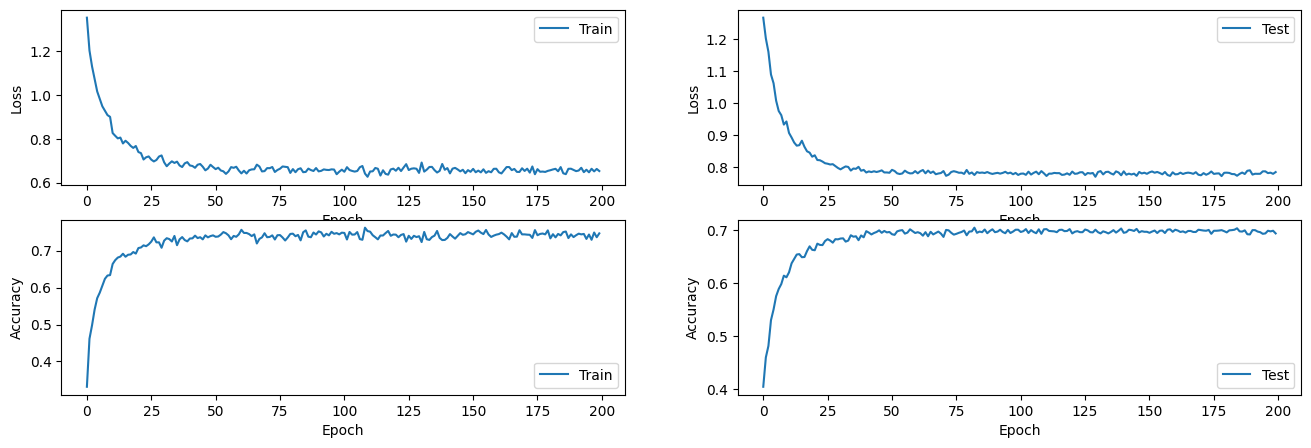

In [124]:
visualize(train_losses, test_losses, train_acc, test_acc)

# 5. Hyper parameters tuning

In [126]:
parameters = {
    "model_params": {
        "num_classes": 4
    },
    "lr": [0.0001, 0.0005, 0.001, 0.005],
    "weight_decay": [0.001, 0.01],
    "step_size": [5, 10, 20],  # Discrete values
    "gamma": [0.1, 0.5, 0.9],
    "batch_size": [8, 16, 32, 64, 128]  # Add batch size options
}

In [ ]:
def hyper_tuning_model(model_class, train_dataset, test_dataset, parameters, device, epochs=50, wandb_writer=None):
    keys, values = zip(*parameters.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_params = None
    best_acc = 0
    results = []

    i = 0
    for params_set in combinations:
        model_params = params_set['model_params']
        batch_size = params_set['batch_size']
        lr = params_set['lr']
        weight_decay = params_set['weight_decay']
        step_size = params_set['step_size']
        gamma = params_set['gamma']
        
        model = model(**model_params)
        
        train_loader = DataLoader(train_dataset, batch_size=params_set['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params_set['batch_size'], shuffle=False)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        epochs = 50
        save_path = f'/kaggle/working/eeg_net_set{i}.pth'
        i += 1
        train_losses, train_acc, test_losses, test_acc = train_model(model, train_loader, test_loader, 
                                                                     criterion, optimizer, scheduler, 
                                                                     save_path, device, 
                                                                     epochs=epochs, wandb_writer=wandb_writer)

        if np.max(test_acc) > best_acc:
            best_params = params_set
            best_acc = np.max(test_acc)

        results.append({
            'params': params_set,
            'train_losses': train_losses,
            'train_acc': train_acc,
            'test_losses': test_losses,
            'test_acc': test_acc,
        })

        return best_params, best_acc, results
        